<a href="https://www.kaggle.com/code/kmljts/real-time-video-dehazing-using-lightclearnet?scriptVersionId=181140091" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [149]:
!pip list | grep opencv

opencv-contrib-python                    4.9.0.80
opencv-python                            4.9.0.80
opencv-python-headless                   4.9.0.80


In [150]:
!pip install pytube

In [151]:
import torch
from torchvision import transforms
import cv2
import numpy as np

from pytube import YouTube
from IPython.display import display, clear_output, Image
from timeit import default_timer as timer
import time

In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [153]:
model_loc = '/kaggle/input/lightclearnet/pytorch/7epochs-21.2462-85.50/1/full-model-jit.pth'
model = torch.jit.load(model_loc, map_location=device).to(device)
model.__class__.__name__ = model.original_name

model

LightClearNet(
  original_name=LightClearNet
  (enc_conv1): LightClearNet(original_name=Conv2d)
  (enc_bn1): LightClearNet(original_name=BatchNorm2d)
  (enc_conv2): LightClearNet(original_name=Conv2d)
  (enc_bn2): LightClearNet(original_name=BatchNorm2d)
  (enc_conv3): LightClearNet(original_name=Conv2d)
  (enc_bn3): LightClearNet(original_name=BatchNorm2d)
  (dec_conv1): LightClearNet(original_name=Conv2d)
  (dec_bn1): LightClearNet(original_name=BatchNorm2d)
  (dec_conv2): LightClearNet(original_name=Conv2d)
  (dec_bn2): LightClearNet(original_name=BatchNorm2d)
  (dec_conv3): LightClearNet(original_name=Conv2d)
)

In [154]:
def cv2_frame_to_img(frame):
    return Image(cv2.imencode('.jpg', frame)[1])

def resize_frame(frame, height=400):
    h, w, c = frame.shape
    scale = height / float(h)
    width = int(w * scale)
    
    return cv2.resize(frame, (width, height))

def frame_dehazer(frame, resize):
    if resize:
        frame = resize_frame(frame)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).astype(np.float32)
    frame_rgb /= 255.0
    tensor = transforms.ToTensor()(frame_rgb).unsqueeze(0).to(device)
    
    model.eval()
    with torch.inference_mode():
        pred = model(tensor).squeeze(0)
    
    pred = pred.permute(1, 2, 0)
    dehazed_frame = pred.cpu().numpy()
    dehazed_frame = (dehazed_frame * 255.0).astype(np.uint8)
    dehazed_frame = cv2.cvtColor(dehazed_frame, cv2.COLOR_BGR2RGB)
    
    new_frame = cv2.hconcat([frame, dehazed_frame])
    return new_frame

In [155]:
yt_urls = {
    'dark_forest': 'https://www.youtube.com/watch?v=LVanPoKh7Ew',
    'autumn_forest': 'https://www.youtube.com/watch?v=USa5se_T7TE',
    'bright_forest': 'https://www.youtube.com/watch?v=DhsKd0Ln0M8',
    'short_clip': 'https://www.youtube.com/watch?v=SgFkqkB6nvM',
    'light_fog': 'https://www.youtube.com/watch?v=-pIkWiNJikw',
    'almost_still_vid': 'https://www.youtube.com/watch?v=8plwv25NYRo',
}

yt_urls

{'dark_forest': 'https://www.youtube.com/watch?v=LVanPoKh7Ew',
 'autumn_forest': 'https://www.youtube.com/watch?v=USa5se_T7TE',
 'bright_forest': 'https://www.youtube.com/watch?v=DhsKd0Ln0M8',
 'short_clip': 'https://www.youtube.com/watch?v=SgFkqkB6nvM',
 'light_fog': 'https://www.youtube.com/watch?v=-pIkWiNJikw',
 'almost_still_vid': 'https://www.youtube.com/watch?v=8plwv25NYRo'}

In [164]:
url = yt_urls['almost_still_vid']

yt = YouTube(url)
stream = yt.streams.get_highest_resolution()
# stream = yt.streams.filter(res='480p').first()
# stream = yt.streams.first()

stream

<Stream: itag="22" mime_type="video/mp4" res="720p" fps="25fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">

In [165]:
stream.title, stream.default_filename, stream.resolution, stream.fps
# stream.download()

('10 Hours of Rain Sound Relaxation / Ultimate Stress Relief, Deep Sleep, Meditation, Yoga,...',
 '10 Hours of Rain Sound Relaxation  Ultimate Stress Relief Deep Sleep Meditation Yoga.mp4',
 '720p',
 25)

In [166]:
stream_fps = stream.fps
stream_url = stream.url

stream_fps, stream_url

(25,
 'https://rr1---sn-5ualdnse.googlevideo.com/videoplayback?expire=1717385047&ei=9-JcZr_tIYapkucPtZWg2AY&ip=34.73.109.30&id=o-AHevp3cDWYK6OYNYnqTMbyHDVJAmKprlSUmWKv8b9VBr&itag=22&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&mh=2f&mm=31%2C29&mn=sn-5ualdnse%2Csn-5uaeznrz&ms=au%2Crdu&mv=m&mvi=1&pl=20&initcwndbps=6601250&bui=AbKP-1NBTxIdVWkFA2Fl62sEnK5iexAT6k4AgIp4LWMTzJzb3w5s2MJKGgsurM4hoOUW7vw7PlNkHgOX&vprv=1&mime=video%2Fmp4&rqh=1&cnr=14&ratebypass=yes&dur=36610.275&lmt=1704734275924532&mt=1717363003&fvip=2&c=ANDROID_EMBEDDED_PLAYER&txp=4532434&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cxpc%2Cbui%2Cvprv%2Cmime%2Crqh%2Ccnr%2Cratebypass%2Cdur%2Clmt&sig=AJfQdSswRQIhANrymey3qIfUqf13VHiZky5JfRbG16PlDZMIptGYd9R-AiATmyB9ur93ztkLOan1yLvDeID2oouQsRH9hpbnW7nwJg%3D%3D&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpl%2Cinitcwndbps&lsig=AHlkHjAwRQIgbCA8xOSA38ZI8ouwXoNXdMJ6pfQ9SaiC7WL_6ltaW_MCIQD5e8cpy1qi3RlPIWbpTZeSHg3rReR9aBs1qNfpJ4clbA%3D%3D')

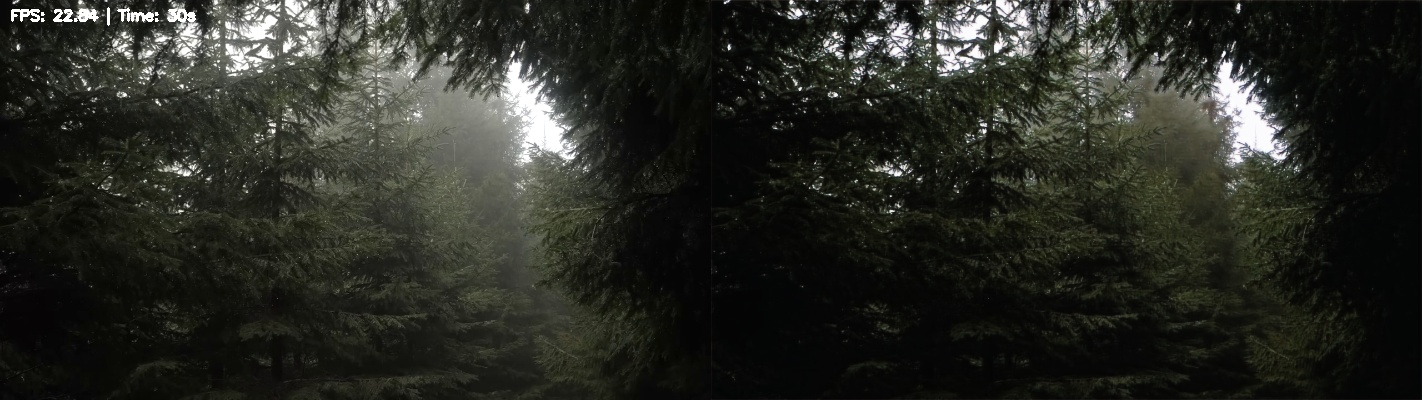

In [167]:
cap = cv2.VideoCapture(stream_url)

resize = True
start_vid_after_seconds = 0
early_stop, stop_after_secs = True, 30
fps = stream_fps
frames = 0

while True:
    start_time = timer()
    
    ret, frame = cap.read()
    if not ret:
        print('No frames returned.')
        break
    frames += 1
    
    if frames < start_vid_after_seconds * stream_fps: 
        if frames % 100 == 0:
            display(frames / stream_fps)
            clear_output(wait=True)
        continue
        
    dehazed_frame = frame_dehazer(frame, resize)
    cv2.putText(
        dehazed_frame,
        text = f'FPS: {fps:.2f} | Time: {round(frames / stream_fps)}s',
        org = (10, 20),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX,
        fontScale = 0.5,
        color = (255, 255, 255), # white
        thickness = 2
    )
    
    display(cv2_frame_to_img(dehazed_frame))
    clear_output(wait=True)

    end_time = timer()
    
    processing_time = end_time - start_time
    sleep_time = (stream_fps ** -1) - processing_time
    time.sleep(max(sleep_time, 0))
    
    total_time = timer() - start_time
    fps = total_time ** -1
    
    if early_stop and frames > stop_after_secs * stream_fps:
        break
    
cap.release()